In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-community langchain-groq tavily-python pandas

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")

GROQ_API_KEY: ··········
TAVILY_API_KEY: ··········


#### Populate the Database

Fetched and populated a `sqlite` database tailored for this travel assistant. I made sure to update it so the information looks current and realistic. It includes mock data for flights, hotels, car rentals, and excursions—all designed to simulate real travel booking scenarios.

The exact data isn’t critical; it’s meant to support the assistant in handling practical queries during development and testing.


In [3]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()
    with open(local_file, "wb") as f:
        f.write(response.content)
    shutil.copy(local_file, backup_file)


def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_file)

## Tools

Next, I defined the assistant's tools to search the airline's policy manual and manage reservations for flights, hotels, car rentals, and excursions. These tools are reused across the system to ensure consistency and modularity.

The exact implementations aren't critical to understand at this stage—you can focus on how the assistant orchestrates and uses them during conversations.

#### Lookup Company Policies

The assistant can retrieve policy information to answer user questions. Note that **enforcement** of these policies must still be handled within the tools or external APIs, since the language model itself can choose to ignore policy details.


In [4]:
import re
import requests
import numpy as np
from sentence_transformers import SentenceTransformer
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt.strip()} for txt in re.split(r"(?=\n##)", faq_text) if txt.strip()]

class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: np.ndarray):
        self._arr = vectors
        self._docs = docs

    @classmethod
    def from_docs(cls, docs: list, embedder: SentenceTransformer):
        texts = [doc["page_content"] for doc in docs]
        vectors = embedder.encode(texts, normalize_embeddings=True)
        return cls(docs, vectors)

    def query(self, query: str, k: int = 5) -> list[dict]:
        query_vec = embedder.encode([query], normalize_embeddings=True)[0]
        scores = np.dot(self._arr, query_vec)
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": float(scores[idx])}
            for idx in top_k_idx_sorted
        ]

embedder = SentenceTransformer("all-MiniLM-L6-v2")
retriever = VectorStoreRetriever.from_docs(docs, embedder)

@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Flights

Define the (`fetch_user_flight_information`) tool to let the agent see the current user's flight information.  Then define tools to search for flights and manage the passenger's bookings stored in the SQL database.

We then can [access the RunnableConfig](https://python.langchain.com/docs/how_to/tool_configure/#inferring-by-parameter-type) for a given run to check the `passenger_id` of the user accessing this application. The LLM never has to provide these explicitly, they are provided for a given invocation of the graph so that each user cannot access other passengers' booking information.




In [5]:
!pip install python-dateutil

In [6]:
import sqlite3
from datetime import date, datetime
from typing import Optional
from dateutil import parser

import pytz
from langchain_core.runnables import RunnableConfig


@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results



@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[str] = None,
    end_time: Optional[str] = None,
    limit: int = 20,
) -> str:
    """Search for flights based on departure airport, arrival airport, and departure time range.
    Returns a string summary of results or a message if none found."""
    limit = int(limit)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        from dateutil import parser
        start_time_dt = parser.parse(start_time)
        query += " AND scheduled_departure >= ?"
        params.append(start_time_dt.isoformat(sep=' '))

    if end_time:
        from dateutil import parser
        end_time_dt = parser.parse(end_time)
        query += " AND scheduled_departure <= ?"
        params.append(end_time_dt.isoformat(sep=' '))

    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    if not results:
        return "No flights found for the given criteria."
    return "\n".join(
        f"Flight {r['flight_no']} from {r['departure_airport']} to {r['arrival_airport']} departs at {r['scheduled_departure']}"
        for r in results
    )

@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id, *, config: RunnableConfig
) -> str:
    """Update the user's ticket to a new valid flight."""
    new_flight_id = int(new_flight_id)
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """Cancel the user's ticket and remove it from the database."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

#### Car Rental Tools

Once a user books a flight, they likely will want to organize transportation. Define some "car rental" tools to let the user search for and reserve a car at their destination.

In [7]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    rentals = [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]
    if not rentals:
        return "No car rentals found."
    return rentals


@tool
def book_car_rental(rental_id) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    rental_id = int(rental_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    rental_id = int(rental_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    rental_id = int(rental_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

#### Hotels

The user has to sleep! Define some tools to search for and manage hotel reservations.

In [8]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    cursor.execute(query, params)
    results = cursor.fetchall()

    hotels = [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]
    if not hotels:
        return "No hotels found."
    return hotels


@tool
def book_hotel(hotel_id) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    hotel_id = int(hotel_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    hotel_id = int(hotel_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    hotel_id = int(hotel_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

#### Excursions

Finally, define some tools to let the user search for things to do (and make reservations) once they arrive.

In [9]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()
    recommendations = [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]
    if not recommendations:
        return "No recommendations found."
    return recommendations


@tool
def book_excursion(recommendation_id) -> str:
    """
    Book an excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    recommendation_id = int(recommendation_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    recommendation_id = int(recommendation_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    recommendation_id = int(recommendation_id)
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

#### Utilities

Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling (by adding the error to the chat history).

In [10]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [11]:
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

## Conditional Interrupt

In this section, we'll refine our interrupt strategy by categorizing tools as safe (read-only) or sensitive (data-modifying). We'll apply interrupts to the sensitive tools only, allowing the bot to handle simple queries autonomously.

This balances user control and conversational flow, but as we add more tools, our single graph may grow too complex for this "flat" structure. We'll address that in the next section.

Your graph for Part 3 will look something like the following diagram.

<img src="./img/part-3-diagram.png" src="../img/part-3-diagram.png">

#### State

As always, start by defining the graph state. Our state and LLM calling **are identical to** part 2.


#### Define Graph

Now, create the graph. Our graph is almost identical to part 2 **except** we split out the tools into 2 separate nodes. We only interrupt before the tools that are actually making changes to the user's bookings.

#### Example Conversation

Now it's time to try out our newly revised chatbot! Let's run it over the following list of dialog turns. This time, we'll have many fewer confirmations.

#### Part 3 Review

Much better! Our agent is now working well - [check out a LangSmith trace](https://smith.langchain.com/public/a0d64d8b-1714-4cfe-a239-e170ca45e81a/r) of our latest run to inspect its work! You may be satisfied with this design. The code is contained, and it's behaving as desired.

One problem with this design is that we're putting a lot of pressure on a single prompt. If we want to add more tools, or if each tool gets more complicated (more filters, more business logic constraining behavior, etc), it's likely the tool usage and overall behavior of the bot will start to suffer.

In the next section, we show how you can take more control over different user experiences by routing to specialist agents or sub-graphs based on the user's intent.

## Part 4: Specialized Workflows

In the previous sections, we saw how "wide" chat-bots, relying on a single prompt and LLM to handle various user intents, can get us far. However, it's difficult to create **predictably great** user experiences for known intents with this approach.

Alternatively, your graph can detect userintent and select the appropriate workflow or "skill" to satisfy the user's needs. Each workflow can focus on its domain, allowing for isolated improvements without degrading the overall assistant.

In this section, we'll split user experiences into separate sub-graphs, resulting in a structure like this:

<img src="./img/part-4-diagram.png" src="../img/part-4-diagram.png">

In the diagram above, each square wraps an agentic, focused workflow. The primary assistant fields the user's initial queries, and the graph routes to the appropriate "expert" based on the query content.

#### State

We want to keep track of which sub-graph is in control at any given moment. While we _could_ do this through some arithmetic on the message list, it's easier to track as a dedicated **stack**.

Add a `dialog_state` list to the `State` below. Any time a `node` is run and returns a value for `dialog_state`, the `update_dialog_stack` function will be called to determine how to apply the update.

In [12]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_car_rental",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

#### Assistants

This time we will create an assistant **for every workflow**. That means:

1. Flight booking assistant
2. Hotel booking assistant
3. Car rental assistant
4. Excursion assistant
5. and finally, a "primary assistant" to route between these

If you're paying attention, you may recognize this as an example of the **supervisor** design pattern from our Multi-agent examples.

Below, define the `Runnable` objects to power each assistant.
Each `Runnable` has a prompt, LLM, and schemas for the tools scoped to that assistant.
Each *specialized* / delegated assistant additionally can call the `CompleteOrEscalate` tool to indicate that the control flow should be passed back to the primary assistant. This happens if it has successfully completed its work or if the user has changed their mind or needs assistance on something that beyond the scope of that particular workflow.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

parse_tasks_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a task parser. Given a user prompt, extract all tasks and their dependencies. "
        "Output a JSON list of tasks, each with a unique id, description, and a list of ids it depends on. "
        "Example output: "
        "[{{'id': '1', 'description': 'fetch user data', 'depends_on': []}}, "
        "{{'id': '2', 'description': 'analyze data', 'depends_on': ['1']}}, "
        "{{'id': '3', 'description': 'generate report', 'depends_on': ['2']}}]"
    ),
    ("user", "{prompt}")
])
parse_tasks_llm = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=0)
parse_tasks_chain = parse_tasks_prompt | parse_tasks_llm

import json

def extract_tasks_and_dependencies(user_prompt):
    response = parse_tasks_chain.invoke({"prompt": user_prompt})
    try:
        start = response.content.find('[')
        end = response.content.rfind(']')
        tasks_json = response.content[start:end+1]
        tasks = json.loads(tasks_json.replace("'", '"'))
        return tasks
    except Exception as e:
        print("Failed to parse tasks:", e)
        print("LLM output:", response.content)
        return []

def topo_sort(tasks):
    from collections import defaultdict, deque

    graph = defaultdict(list)
    indegree = defaultdict(int)
    task_map = {task['id']: task for task in tasks}
    for task in tasks:
        for dep in task['depends_on']:
            graph[dep].append(task['id'])
            indegree[task['id']] += 1
        if task['id'] not in indegree:
            indegree[task['id']] = 0

    queue = deque([tid for tid, deg in indegree.items() if deg == 0])
    order = []
    while queue:
        tid = queue.popleft()
        order.append(task_map[tid])
        for neighbor in graph[tid]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)
    if len(order) != len(tasks):
        raise ValueError("Cycle detected in task dependencies!")
    return order

In [14]:
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

import time
try:
    from groq import RateLimitError
except ImportError:
    class RateLimitError(Exception):
        pass

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        max_retries = 10
        retries = 0
        while retries < max_retries:
            try:
                result = self.runnable.invoke(state)
                if not result.tool_calls and (
                    not result.content
                    or (isinstance(result.content, list)
                        and not result.content[0].get("text"))
                ):
                    messages = state["messages"] + [("user", "Respond with a real output.")]
                    state = {**state, "messages": messages}
                    retries += 1
                else:
                    return {"messages": result}
            except RateLimitError as e:
                print("Rate limit hit. Waiting 75 seconds before retrying...")
                time.sleep(5)
                retries += 1
        return {"messages": "Sorry, I couldn't get a valid response from the assistant."}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }

llm = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=1)

# Flight booking assistant

flight_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling flight updates. "
            " The primary assistant delegates work to you whenever the user needs help updating their bookings. "
            "Confirm the updated flight details with the customer and inform them of any additional fees. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

update_flight_safe_tools = [search_flights]
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    update_flight_tools + [CompleteOrEscalate]
)

# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling hotel bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a hotel. "
            "Search for available hotels based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Hotel booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_hotel_safe_tools = [search_hotels]
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    book_hotel_tools + [CompleteOrEscalate]
)

# Car Rental Assistant
book_car_rental_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling car rental bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a car rental. "
            "Search for available car rentals based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_car_rental_safe_tools = [search_car_rentals]
book_car_rental_sensitive_tools = [
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
]
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    book_car_rental_tools + [CompleteOrEscalate]
)

# Excursion Assistant

book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling trip recommendations. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Excursion booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_excursion_safe_tools = [search_trip_recommendations]
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    book_excursion_tools + [CompleteOrEscalate]
)


# Primary Assistant
class ToFlightBookingAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle flight updates and cancellations."""

    request: str = Field(
        description="Any necessary followup questions the update flight assistant should clarify before proceeding."
    )


class ToBookCarRental(BaseModel):
    """Transfers work to a specialized assistant to handle car rental bookings."""

    location: str = Field(
        description="The location where the user wants to rent a car."
    )
    start_date: str = Field(description="The start date of the car rental.")
    end_date: str = Field(description="The end date of the car rental.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the car rental."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Basel",
                "start_date": "2023-07-01",
                "end_date": "2023-07-05",
                "request": "I need a compact car with automatic transmission.",
            }
        }


class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(description="The check-in date for the hotel.")
    checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Zurich",
                "checkin_date": "2023-08-15",
                "checkout_date": "2023-08-20",
                "request": "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfers work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description="The location where the user wants to book a recommended trip."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip recommendation."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Lucerne",
                "request": "The user is interested in outdoor activities and scenic views.",
            }
        }


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            "Your primary role is to search for flight information and company policies to answer customer queries. "
            "If a customer requests to update or cancel a flight, book a car rental, book a hotel, or get trip recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)
primary_assistant_tools = [
    TavilySearchResults(max_results=1),
    search_flights,
    lookup_policy,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToFlightBookingAssistant,
        ToBookCarRental,
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

/tmp/ipython-input-14-4054001732.py:290: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  TavilySearchResults(max_results=1),


#### Create Assistant

We're about ready to create the graph. In the previous section, we made the design decision to have a shared `messages` state between all the nodes. This is powerful in that each delegated assistant can see the entire user journey and have a shared context. This, however, means that weaker LLMs can easily get mixed up about there specific scope. To mark the "handoff" between the primary assistant and one of the delegated workflows (and complete the tool call from the router), we will add a `ToolMessage` to the state.


#### Utility

Create a function to make an "entry" node for each workflow, stating "the current assistant is `assistant_name`".

In [15]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

#### Define Graph

Now it's time to start building our graph. As before, we'll start with a node to pre-populate the state with the user's current information.

In [16]:
from typing import Literal

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import START,END,StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

Now we'll start adding our specialized workflows. Each mini-workflow looks very similar to our full graph in [Part 3](#part-3-conditional-interrupt), employing 5 nodes:

1. `enter_*`: use the `create_entry_node` utility you defined above to add a ToolMessage signaling that the new specialized assistant is at the helm
2. Assistant: the prompt + llm combo that takes in the current state and either uses a tool, asks a question of the user, or ends the workflow (return to the primary assistant)
3. `*_safe_tools`: "read-only" tools the assistant can use without user confirmation.
4. `*_sensitive_tools`: tools with "write" access that require user confirmation (and will be assigned an `interrupt_before` when we compile the graph)
5. `leave_skill`: _pop_ the `dialog_state` to signal that the *primary assistant* is back in control

Because of their similarities, we _could_ define a factory function to generate these. Since this is a tutorial, we'll define them each explicitly.

First, make the **flight booking assistant** dedicated to managing the user journey for updating and canceling flights.

In [17]:
# Flight booking assistant
builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Updates & Booking Assistant", "update_flight"),
)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_edge("enter_update_flight", "update_flight")
builder.add_node(
    "update_flight_sensitive_tools",
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    "update_flight_safe_tools",
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    return "update_flight_sensitive_tools"


builder.add_edge("update_flight_sensitive_tools", "fetch_user_info")
builder.add_edge("update_flight_safe_tools", "update_flight")
builder.add_conditional_edges(
    "update_flight",
    route_update_flight,
    ["update_flight_sensitive_tools", "update_flight_safe_tools", "leave_skill", END],
)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

Next, create the **car rental assistant** graph to own all car rental needs.

In [18]:
# Car rental assistant

builder.add_node(
    "enter_book_car_rental",
    create_entry_node("Car Rental Assistant", "book_car_rental"),
)
builder.add_node("book_car_rental", Assistant(book_car_rental_runnable))
builder.add_edge("enter_book_car_rental", "book_car_rental")
builder.add_node(
    "book_car_rental_safe_tools",
    create_tool_node_with_fallback(book_car_rental_safe_tools),
)
builder.add_node(
    "book_car_rental_sensitive_tools",
    create_tool_node_with_fallback(book_car_rental_sensitive_tools),
)


def route_book_car_rental(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_car_rental_safe_tools"
    return "book_car_rental_sensitive_tools"


builder.add_edge("book_car_rental_sensitive_tools", "fetch_user_info")
builder.add_edge("book_car_rental_safe_tools", "book_car_rental")
builder.add_conditional_edges(
    "book_car_rental",
    route_book_car_rental,
    [
        "book_car_rental_safe_tools",
        "book_car_rental_sensitive_tools",
        "leave_skill",
        END,
    ],
)

Then define the **hotel booking** workflow.

In [19]:
# Hotel booking assistant
builder.add_node(
    "enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel")
)
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "fetch_user_info")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges(
    "book_hotel",
    route_book_hotel,
    ["leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", END],
)

After that, define the **excursion assistant**.

In [20]:
# Excursion assistant
builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_node(
    "book_excursion_safe_tools",
    create_tool_node_with_fallback(book_excursion_safe_tools),
)
builder.add_node(
    "book_excursion_sensitive_tools",
    create_tool_node_with_fallback(book_excursion_sensitive_tools),
)


def route_book_excursion(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"


builder.add_edge("book_excursion_sensitive_tools", "fetch_user_info")
builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_conditional_edges(
    "book_excursion",
    route_book_excursion,
    ["book_excursion_safe_tools", "book_excursion_sensitive_tools", "leave_skill", END],
)

Finally, create the **primary assistant**.

In [21]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToFlightBookingAssistant.__name__:
            return "enter_update_flight"
        elif tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_book_car_rental"
        elif tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_update_flight",
        "enter_book_car_rental",
        "enter_book_hotel",
        "enter_book_excursion",
        "primary_assistant_tools",
        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "update_flight",
    "book_car_rental",
    "book_hotel",
    "book_excursion",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = InMemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "update_flight_sensitive_tools",
        "book_car_rental_sensitive_tools",
        "book_hotel_sensitive_tools",
        "book_excursion_sensitive_tools",
    ],
)

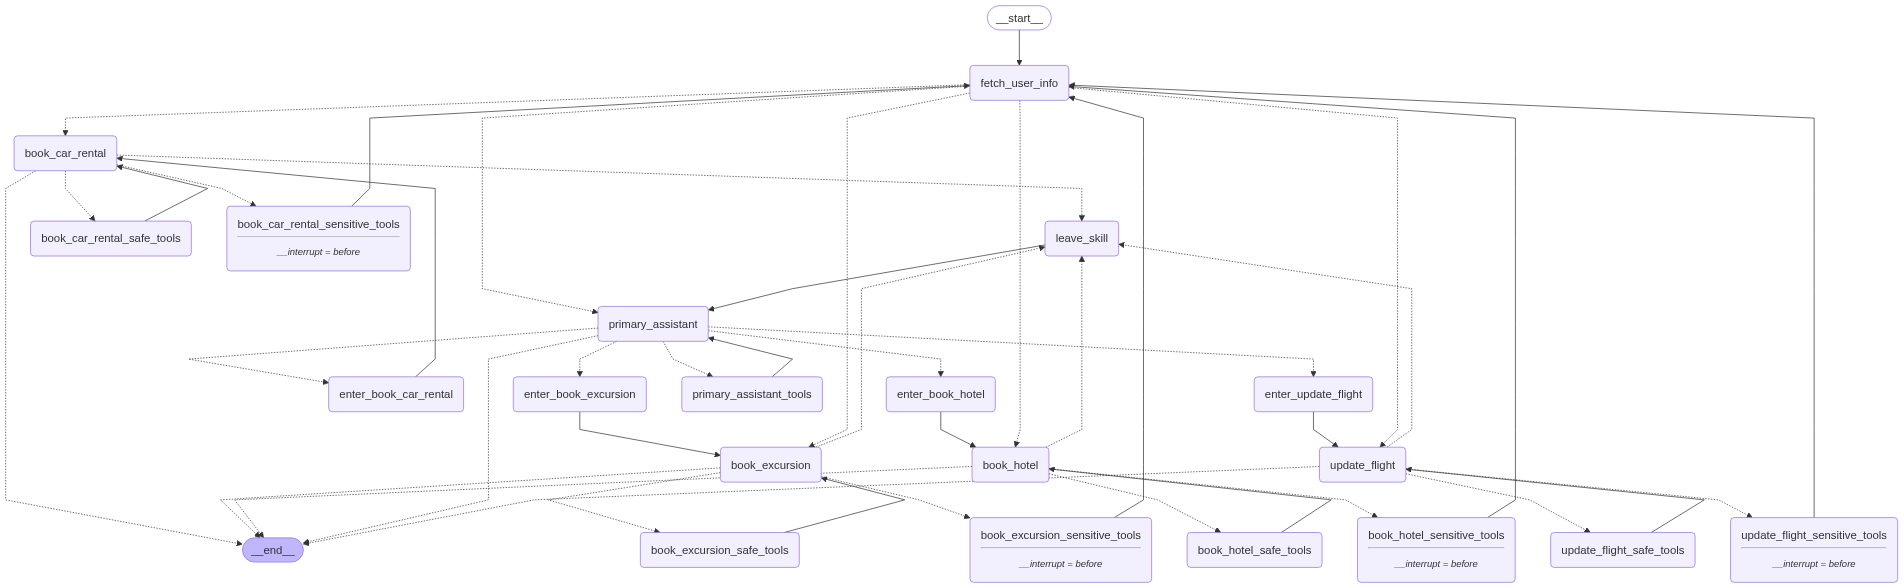

In [22]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
def safe_tool_message(event, user_input):
    tool_call_id = None
    if "messages" in event and event["messages"] and hasattr(event["messages"][-1], "tool_calls"):
        tool_calls = event["messages"][-1].tool_calls
        if tool_calls and "id" in tool_calls[0]:
            tool_call_id = tool_calls[0]["id"]
    if not tool_call_id:
        tool_call_id = "unknown"
    return ToolMessage(
        tool_call_id=tool_call_id,
        content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
    )

In [24]:
import shutil
import uuid


def orchestrate_prompt_with_dependencies(user_prompt, config):
    tasks = extract_tasks_and_dependencies(user_prompt)
    if not tasks or len(tasks) == 1:
        return part_4_graph.stream(
            {"messages": ("user", user_prompt)}, config, stream_mode="values"
        )
    ordered_tasks = topo_sort(tasks)
    results = []
    for task in ordered_tasks:
        events = part_4_graph.stream(
            {"messages": ("user", task['description'])}, config, stream_mode="values"
        )
        task_result = [event for event in events]
        results.append({"task": task, "result": task_result})
    return results

# Main loop

db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "passenger_id": "3442 587242",
        "thread_id": thread_id,
    }
}

_printed = set()
while True:
    question = input("Ask your travel question (or type 'exit' to quit): ")
    if question.lower() in ["exit", "quit"]:
        break

    results = orchestrate_prompt_with_dependencies(question, config)
    if isinstance(results, list):
        for res in results:
            print(f"\nTask: {res['task']['description']}")
            for event in res['result']:
                _print_event(event, _printed)
            snapshot = part_4_graph.get_state(config)
            while snapshot.next:
                try:
                    user_input = input(
                        "Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed.\n\n"
                    )
                except:
                    user_input = "y"
                if user_input.strip() == "y":
                    part_4_graph.invoke(None, config)
                else:
                    part_4_graph.invoke(
                        {
                            "messages": [
                                safe_tool_message(event, user_input)
                            ]
                        },
                        config,
                    )
                snapshot = part_4_graph.get_state(config)
    else:
        for event in results:
            _print_event(event, _printed)
        snapshot = part_4_graph.get_state(config)
        while snapshot.next:
            try:
                user_input = input(
                    "Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed.\n\n"
                )
            except:
                user_input = "y"
            if user_input.strip() == "y":
                part_4_graph.invoke(None, config)
            else:
                part_4_graph.invoke(
                    {
                        "messages": [
                            safe_tool_message(event, user_input)
                        ]
                    },
                    config,
                )
            snapshot = part_4_graph.get_state(config)

Ask your travel question (or type 'exit' to quit): First, fetch my flight details and hotel options. Once I have my flight details, book a car rental. Only after both the hotel options and car rental are ready, book an excursion
Failed to parse tasks: Extra data: line 1 column 6 (char 5)
LLM output: <think>
Okay, so I need to figure out how to parse the user's prompt into tasks and their dependencies. The user provided an example where each task has an id, description, and depends_on list. Let me break down the prompt step by step.

The prompt says: "First, fetch my flight details and hotel options. Once I have my flight details, book a car rental. Only after both the hotel options and car rental are ready, book an excursion."

Hmm, so the first part mentions two initial tasks: fetch flight details and fetch hotel options. These seem to be independent because they don't depend on anything else. So I'll assign them as Task 1 and Task 2.

Next, it says once I have my flight details, book

In [ ]:
import shutil
import uuid


def orchestrate_prompt_with_dependencies(user_prompt, config):
    tasks = extract_tasks_and_dependencies(user_prompt)
    if not tasks or len(tasks) == 1:
        return part_4_graph.stream(
            {"messages": ("user", user_prompt)}, config, stream_mode="values"
        )
    ordered_tasks = topo_sort(tasks)
    results = []
    for task in ordered_tasks:
        events = part_4_graph.stream(
            {"messages": ("user", task['description'])}, config, stream_mode="values"
        )
        task_result = [event for event in events]
        results.append({"task": task, "result": task_result})
    return results

# Main loop

db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "passenger_id": "3442 587242",
        "thread_id": thread_id,
    }
}

_printed = set()
while True:
    question = input("Ask your travel question (or type 'exit' to quit): ")
    if question.lower() in ["exit", "quit"]:
        break

    results = orchestrate_prompt_with_dependencies(question, config)
    if isinstance(results, list):
        for res in results:
            print(f"\nTask: {res['task']['description']}")
            for event in res['result']:
                _print_event(event, _printed)
            snapshot = part_4_graph.get_state(config)
            while snapshot.next:
                try:
                    user_input = input(
                        "Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed.\n\n"
                    )
                except:
                    user_input = "y"
                if user_input.strip() == "y":
                    part_4_graph.invoke(None, config)
                else:
                    part_4_graph.invoke(
                        {
                            "messages": [
                                safe_tool_message(event, user_input)
                            ]
                        },
                        config,
                    )
                snapshot = part_4_graph.get_state(config)
    else:
        for event in results:
            _print_event(event, _printed)
        snapshot = part_4_graph.get_state(config)
        while snapshot.next:
            try:
                user_input = input(
                    "Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed.\n\n"
                )
            except:
                user_input = "y"
            if user_input.strip() == "y":
                part_4_graph.invoke(None, config)
            else:
                part_4_graph.invoke(
                    {
                        "messages": [
                            safe_tool_message(event, user_input)
                        ]
                    },
                    config,
                )
            snapshot = part_4_graph.get_state(config)


Ask your travel question (or type 'exit' to quit): Hi there what's my upcoming flight?
Failed to parse tasks: Extra data: line 1 column 7 (char 6)
LLM output: <think>
Okay, so the user asked, "Hi there what's my upcoming flight?" and I need to figure out how to respond. First, I should understand what they're really looking for. They probably want information about their next flight, like the departure time, destination, or maybe the booking details.

I remember that to get someone's flight info, I need to access their personal data. So the first step would be to fetch their user data. That makes sense because without knowing who they are, I can't look up their flight details.

Once I have their user data, the next logical step is to fetch the specific flight information. I can't just stop at getting their data; I need to use that data to find out about their flight. So, the second task would be to fetch the flight details using the information from the first task.

I should make sure 